In [17]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import liana as li
import numpy as np

from matplotlib import pyplot as plt

In [18]:
# TODO: move such functions to a common utils folder
from classification.prep_utils import filter_samples
from classification.classify_utils import INVERSE_FUN

In [19]:
# insert modules from ./classification/classify_utils.py
from classification.processer import DatasetHandler

In [20]:
cell_pairs = pd.read_csv('ct_interactions.csv')[['target', 'predictor']]

In [21]:
# join target and predictor
# Predictor as Source

# join the same but with predictor and target swapped
cell_pairs2 = cell_pairs.copy().rename(columns={'target': 'predictor', 'predictor': 'target'})
interactions = pd.concat([cell_pairs, cell_pairs2], axis=0)

# same to same
autocrine = list(np.union1d(interactions['target'].unique(), interactions['predictor'].unique()))
autocrine = pd.DataFrame(zip(autocrine, autocrine), columns=['target', 'predictor'])

cell_pairs = pd.concat([interactions, autocrine], axis=0)
cell_pairs = cell_pairs.rename(columns={'predictor': 'source'})[['source', 'target']]

In [22]:
cell_pairs.head()

,source,target
0,Endothelial,Cardiomyocyte
1,Lymphoid,Cardiomyocyte
2,Neuronal,Cardiomyocyte
3,Pericyte,Cardiomyocyte
4,Adipocyte,Endothelial


(array([273.,  91.,  81.,  60.,  71.,  69.,  81.,  85.,  90.,  98.,  91.,
        104.,  76.,  77.,  53.,  55.,  47.,  33.,  38.,  38.,  31.,  32.,
         27.,  24.,  21.,  16.,  17.,  22.,  13.,   6.,  11.,   7.,  13.,
          2.,   8.,   5.,   4.,   5.,   4.,   5.,   1.,   1.,   1.,   4.,
          2.,   2.,   1.,   0.,   1.,   2.]),
 array([0.        , 0.09780448, 0.19560896, 0.29341344, 0.39121792,
        0.4890224 , 0.58682688, 0.68463136, 0.78243584, 0.88024032,
        0.9780448 , 1.07584928, 1.17365376, 1.27145824, 1.36926272,
        1.4670672 , 1.56487168, 1.66267616, 1.76048064, 1.85828512,
        1.9560896 , 2.05389408, 2.15169856, 2.24950304, 2.34730752,
        2.445112  , 2.54291648, 2.64072096, 2.73852544, 2.83632992,
        2.9341344 , 3.03193888, 3.12974336, 3.22754784, 3.32535232,
        3.4231568 , 3.52096128, 3.61876576, 3.71657024, 3.81437472,
        3.9121792 , 4.00998368, 4.10778816, 4.20559264, 4.30339712,
        4.4012016 , 4.49900608, 4.59681056, 4.

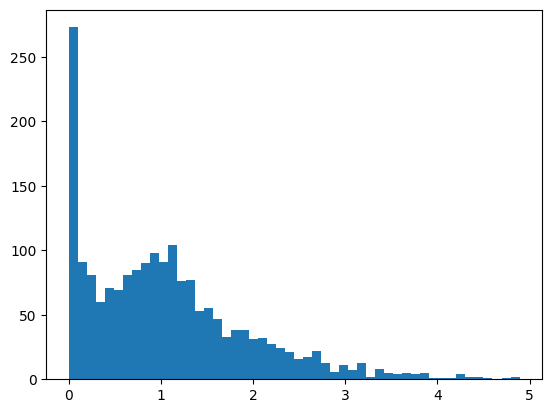

In [23]:
lr_nmf = pd.read_csv(os.path.join('kuppe_visium', 'results', 'lr_loadings.csv'), index_col=0)
# pivot longer
lr_nmf = lr_nmf.reset_index().melt(id_vars='index', var_name='factor', value_name='loading')
plt.hist(lr_nmf['loading'], bins=50)

In [24]:
# keep interactions with loading > 0.5 in any factor
lr_nmf = lr_nmf.query('loading > 0.5')
# separete by ^ into ligand and receptor
lr_nmf['ligand'] = lr_nmf['index'].str.split('^').str[0]
lr_nmf['receptor'] = lr_nmf['index'].str.split('^').str[1]
resource = lr_nmf[['ligand', 'receptor']].drop_duplicates()

Dataset params

In [25]:
dataset_name = 'kuppe'
ds = DatasetHandler('kuppe')
dataset_info = ds.dataset_params['kuppe']
defaults = ds.dataset_params['defaults']

In [26]:
dataset_name = dataset_name
groupby = 'cell_type_original' # NOTE: the same cell types but readable
sample_key = dataset_info.get('sample_key', defaults['sample_key'])
condition_key = dataset_info.get('condition_key', defaults['condition_key'])
min_cells_per_sample = dataset_info.get('min_cells_per_sample', defaults['min_cells_per_sample'])
sample_zcounts_max = dataset_info.get('sample_zcounts_max', defaults['sample_zcounts_max'])
sample_zcounts_min = dataset_info.get('sample_zcounts_min', defaults['sample_zcounts_min'])
min_cells = dataset_info.get('min_cells', defaults['min_cells'])
min_samples = dataset_info.get('min_samples', defaults['min_samples'])
use_raw = dataset_info.get('use_raw', defaults['use_raw'])
change_var_to = dataset_info.get('change_var_to', defaults['change_var_to'])
conditions_to_keep = dataset_info.get('conditions_to_keep', defaults['conditions_to_keep'])
n_factors = dataset_info.get('n_factors', defaults['n_factors'])

Process Full Dataset

In [27]:
adata = sc.read_h5ad(os.path.join('classification', 'data', 'kuppe.h5ad'), backed='r')

In [28]:
adata.obs[[condition_key, sample_key]].drop_duplicates().groupby(condition_key).count()

,sample
patient_group,
fibrotic,5
ischemic,11
myogenic,13


In [29]:
# remap
remap = {'vSMCs':'Vascular_SMCs'}
adata.obs[groupby].replace(remap, inplace=True)

In [30]:
adata.obs[groupby]

AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1       Fibroblast
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    Cardiomyocyte
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    Cardiomyocyte
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1       Fibroblast
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    Cardiomyocyte
                                                      ...      
TTTCATGGTCTTGCTC-1                                   Fibroblast
TTTCCTCAGGTTCATC-1                                     Lymphoid
TTTCGATTCCGGTAAT-1                                      Myeloid
TTTGACTTCGCCAACG-1                                  Endothelial
TTTGGTTGTGCCCAGT-1                                      Myeloid
Name: cell_type_original, Length: 191795, dtype: category
Categories (11, object): ['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', ..., 'Myeloid', 'Neuronal', 'Pericyte', 'Vascular_SMCs']

In [31]:
# # keep only targets of interest
# msk = adata.obs[groupby].isin(interactions['target'])
# adata = adata[msk, :]

In [32]:
adata = adata.to_memory().raw.to_adata()

In [33]:
adata = filter_samples(adata,
                        sample_key = sample_key,
                        condition_key = condition_key,
                        min_cells_per_sample= min_cells_per_sample,
                        sample_zcounts_max= sample_zcounts_max,
                        sample_zcounts_min= sample_zcounts_min)

               sample
patient_group        
fibrotic            5
ischemic           10
myogenic           13


In [34]:
import gc
gc.collect()

592

In [35]:
# Remove genes expressed in few cells, normalize
sc.pp.filter_genes(adata, min_cells=min_cells)

/home/dbdimitrov/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


In [36]:
# Change to Gene Symbol
adata.var.index = adata.var[change_var_to]

In [37]:
adata.layers['counts'] = adata.X.copy()

In [38]:
# Normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [39]:
# write to file
adata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'))

In [40]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [41]:
import gc
gc.collect()

2394

In [42]:
# Run LIANA (NOTE: should be by method in a sep function)
li.mt.rank_aggregate.by_sample(adata, 
                               groupby=groupby,
                               use_raw=False,
                               sample_key=sample_key,
                               verbose=True,
                               n_perms=None,
                               resource=resource,
                               groupby_pairs=cell_pairs,
                               )

Now running: CK376: 100%|██████████| 28/28 [03:16<00:00,  7.00s/it]


In [43]:
# write to file
adata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'))

Run LIANA + MOFA

In [44]:
import muon as mu
import plotnine as p9
import mofax as mofa

In [45]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [46]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.3, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 10, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 40/40 [00:00<00:00, 150.24it/s]


In [47]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   outfile='models/mofatalk.h5ad',
                   seed=1337,
                   n_factors=10,
                   convergence_mode='slow',
                   scale_views=True,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='Cardiomyocyte&Cardiomyocyte' group='group1' with N=28 samples and D=249 features...
Loaded view='Neuronal&Cardiomyocyte' group='group1' with N=28 samples and D=234 features...
Loaded view='Cardiomyocyte&Pericyte' group='group1' with N=28 samples and D=191 features...
Loaded view='Cardiomyocyte&Lymphoid' group='group1' with N=28 sam

In [48]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-3.509228,0.131843,-0.071002,-0.055124,-0.173919,-0.177744,-0.331476,-0.080045,-0.043448,-0.043321,myogenic
1,CK159,0.352963,0.151931,-0.070196,-0.054810,-0.177351,-0.192615,-0.331591,-0.080240,-0.043564,-0.044917,myogenic
2,CK160,0.149783,0.074958,-0.072068,-0.054368,-0.179451,-0.147987,-0.335140,-0.078935,-0.041832,-0.042786,myogenic
3,CK162,0.819009,0.146445,-0.070726,-0.054891,-0.176867,-0.190726,-0.331697,-0.079663,-0.043988,1.184629,fibrotic
4,CK163,-0.455307,0.151118,-0.070720,-0.054669,-0.177396,-0.189764,-0.329684,-0.079915,-0.043943,-0.044242,myogenic


In [49]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 7053
Groups: group1 (28)
Views: Adipocyte&Adipocyte (74), Adipocyte&Endothelial (111), Adipocyte&Fibroblast (124), Adipocyte&Vascular_SMCs (108), Cardiomyocyte&Cardiomyocyte (249), Cardiomyocyte&Endothelial (194), Cardiomyocyte&Lymphoid (144), Cardiomyocyte&Neuronal (200), Cardiomyocyte&Pericyte (191), Endothelial&Adipocyte (96), Endothelial&Cardiomyocyte (234), Endothelial&Endothelial (178), Endothelial&Fibroblast (205), Endothelial&Pericyte (176), Endothelial&Vascular_SMCs (236), Fibroblast&Adipocyte (115), Fibroblast&Endothelial (214), Fibroblast&Fibroblast (244), Fibroblast&Mast (197), Fibroblast&Myeloid (190), Fibroblast&Neuronal (215), Fibroblast&Vascular_SMCs (283), Lymphoid&Cardiomyocyte (178), Lymphoid&Lymphoid (84), Lymphoid&Myeloid (115), Mast&Fibroblast (164), Mast&Mast (125), Myeloid&Fibroblast (171), Myeloid&Lymphoid (112), Myeloid&Myeloid (150), Neuronal&Cardiomyocyte (234), Neuronal&Fibroblast (205), Neuronal&Neur

Explore Results

In [50]:
factor_of_interest = "Factor1"

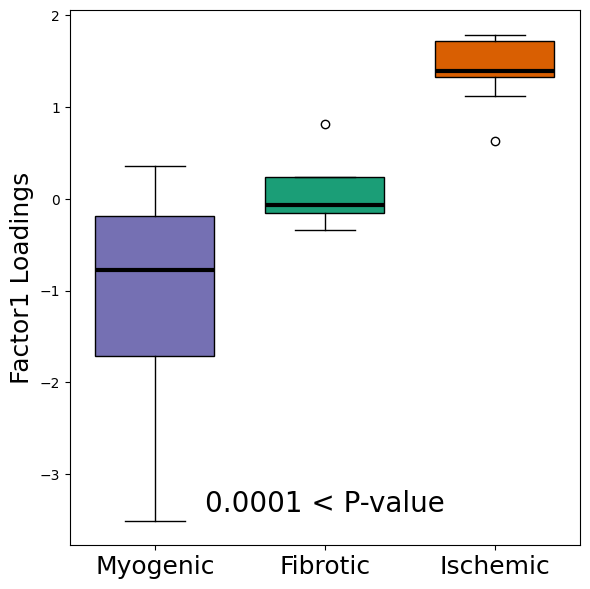

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

# Assuming factor_scores is your DataFrame and condition_key is the column for conditions
factor_scores[condition_key] = factor_scores[condition_key].str.title().astype('category')
labels = ['Myogenic', 'Fibrotic', 'Ischemic']

# Set the color palette and style
colors = ['#7570b3', '#1b9e77', '#d95f02']

# Create a boxplot
plt.figure(figsize=(6, 6))
box_positions = np.arange(1, len(labels) + 1)

for i, label in enumerate(labels):
    subset = factor_scores[factor_scores[condition_key] == label][factor_of_interest]
    plt.boxplot(subset, positions=[box_positions[i]], widths=0.7, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black', linewidth=3))

# Perform one-way ANOVA
groups = [factor_scores[factor_scores[condition_key] == group][factor_of_interest] for group in labels]
statistic, p_value = f_oneway(*groups)

pval = round(p_value, 3)
# Add ANOVA significance if p-value is significant (typically p < 0.05)
plt.text(2, min([group.min() for group in groups]) + 0.1, f'{pval+ 0.0001:.4f} < P-value', ha='center', fontsize=20)

# Set labels and title
plt.xlabel('')
plt.ylabel(f'{factor_of_interest} Loadings', fontsize=18)  # Adjusted font size
plt.title('')
plt.xticks(box_positions, labels, fontsize=18)  # Adjusted font size
plt.tight_layout()

# Show the plot
plt.show()


In [52]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [53]:
variable_loadings.to_csv('kuppe_visium/kuppe_mofa_loadings.csv')

In [54]:
# target = Myeloid and source = Fibroblast
myeloid_loadings = variable_loadings[(variable_loadings['source']=='Myeloid') & (variable_loadings['target']=='Endothelial')]

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


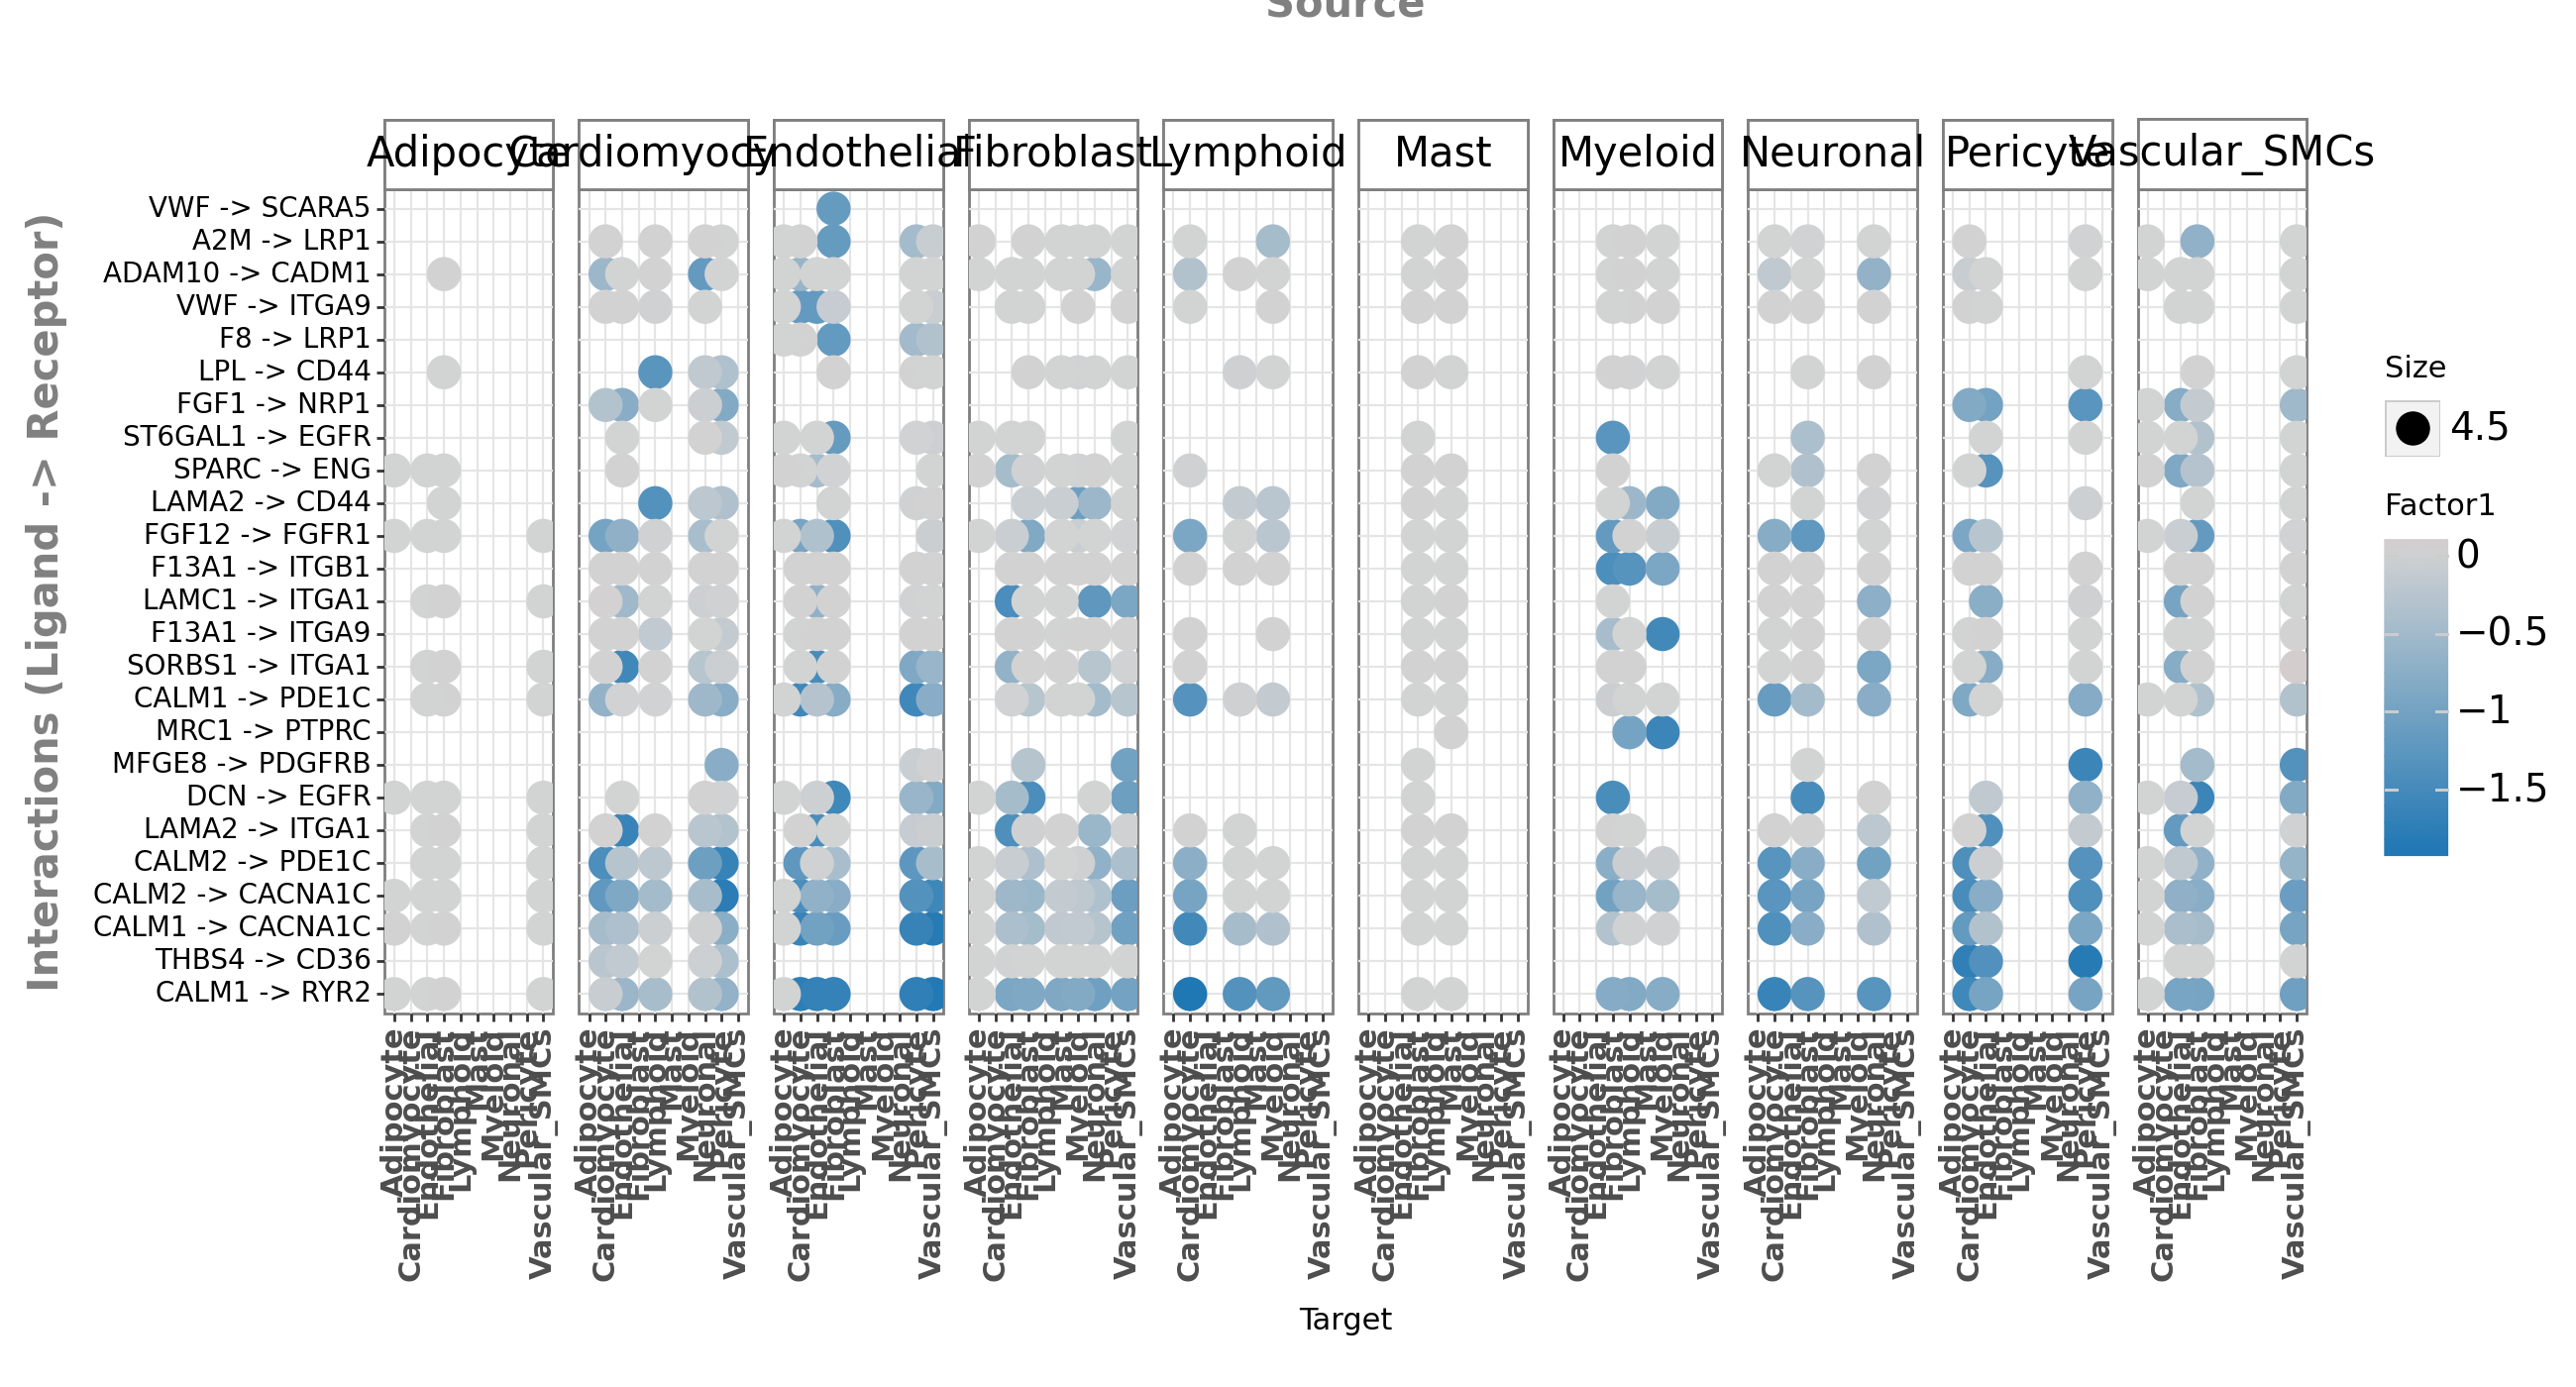

<Figure Size: (1300 x 700)>

In [55]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        top_n=25,
                        orderby_absolute=True,
                        orderby_ascending=False,
                        size_range=(0.1, 6),
                        figure_size=(13, 7)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0)

In [56]:
# import omnipath as op
# inter = op.interactions.import_intercell_network()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


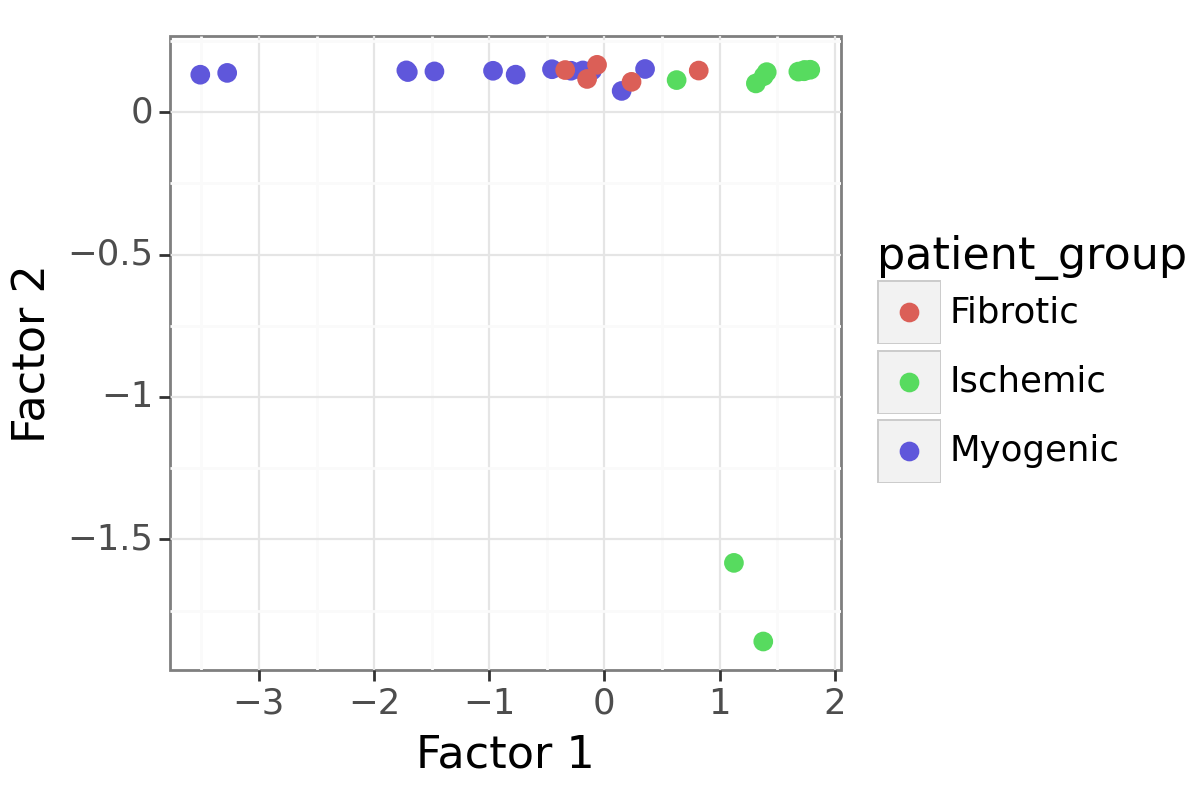

<Figure Size: (600 x 400)>

In [57]:
# dotplot of Factor1 (x) and Factor2 (y)
(
    p9.ggplot(factor_scores) +
    p9.aes(x='Factor1', y='Factor2', colour=condition_key) +
    p9.geom_point(size=3) +
    p9.theme_bw(base_size=16) +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(x='Factor 1', y='Factor 2')
)

Factor 1 R2 per view

In [58]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

In [59]:
factor_rsq['source'] = factor_rsq['source'].astype('category')
factor_rsq['target'] = factor_rsq['target'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


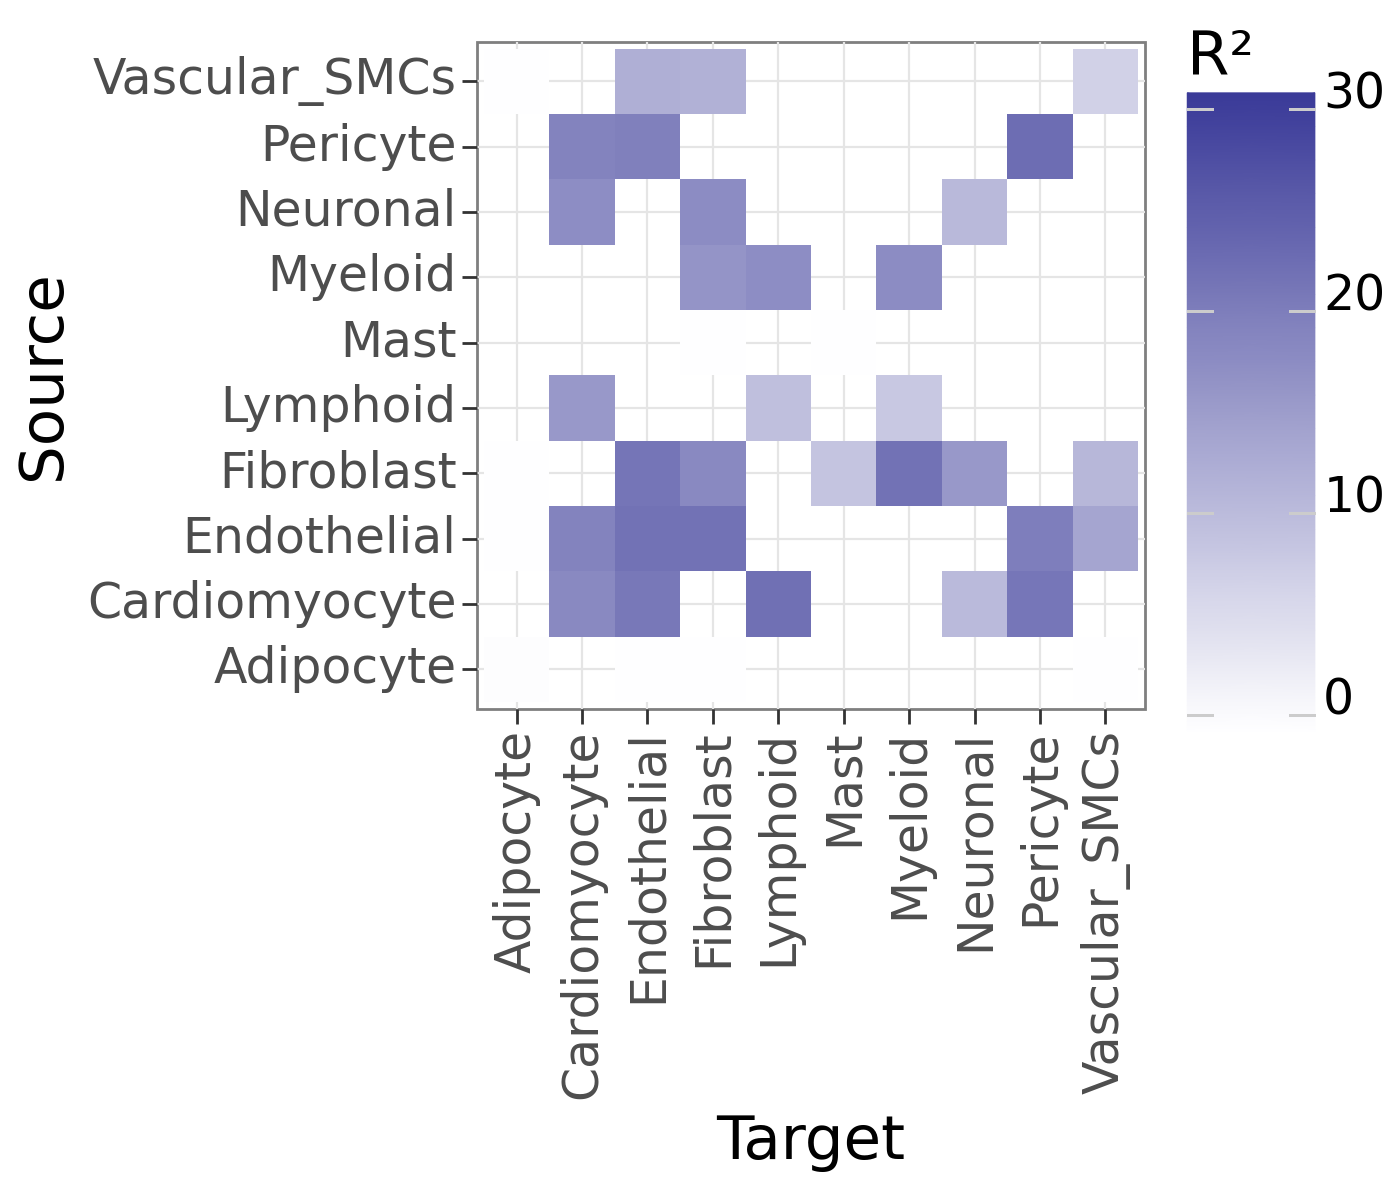

<Figure Size: (700 x 600)>

In [60]:
(p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
#  p9.scale_fill_gradient2(low='white', high='#c20019') +
# limits 
    p9.scale_fill_gradient2(limits=(0, 30)) +
 p9.theme_bw(base_size=22) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(7,6))
)

In [61]:
ct_int = variable_loadings[(variable_loadings['source']=='Cardiomyocyte') & (variable_loadings['target']=='Endothelial')]

In [62]:
# rank by absolute values of Factor 1
ct_int['rank'] = ct_int['Factor1'].rank(ascending=False)

In [63]:
ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(20)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank
929,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.609031,0.088552,-0.028489,-0.032458,-0.017116,-0.008312,-0.008162,0.010263,0.018189,0.002148,4.5,194.0
972,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.523540,0.041705,-0.002581,0.015754,-0.014750,-0.014528,-0.012511,0.020834,0.011136,0.003878,4.5,193.0
930,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-0.930611,-0.058583,0.094317,0.098231,0.020201,0.002990,0.001903,0.009470,-0.004785,0.001628,4.5,192.0
853,CALM2,CACNA1C,Cardiomyocyte,Endothelial,-0.879072,0.139235,-0.027734,-0.058966,0.018996,0.054246,-0.001174,0.015033,0.031245,-0.002079,4.5,191.0
931,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-0.797799,0.030092,0.065105,0.038803,0.066951,0.002032,0.017447,0.005832,-0.003467,0.001040,4.5,190.0
910,FGF1,NRP1,Cardiomyocyte,Endothelial,-0.773113,0.050631,-0.067298,-0.044541,-0.030073,-0.026744,-0.006347,-0.000728,0.012003,-0.001555,4.5,189.0
908,FGF12,FGFR1,Cardiomyocyte,Endothelial,-0.703477,-0.006389,-0.008305,0.008240,0.065204,-0.035433,-0.002077,0.008218,-0.012063,0.000536,4.5,188.0
826,ADAM9,ITGA6,Cardiomyocyte,Endothelial,-0.607875,0.029873,0.021407,-0.006306,-0.031860,-0.011791,-0.003766,-0.005836,0.054757,-0.002613,4.5,187.0
851,CALM1,RYR2,Cardiomyocyte,Endothelial,-0.577271,0.127735,0.117460,-0.104783,-0.000233,-0.001671,0.003144,-0.015072,-0.001251,-0.001477,4.5,186.0
987,TGM2,ITGA9,Cardiomyocyte,Endothelial,-0.554480,0.071192,-0.065940,0.054593,0.092933,0.034256,-0.003558,0.065059,0.031784,-0.000008,4.5,185.0


In [64]:

ct_int['name'] = ct_int['ligand_complex'] + ' -> ' + ct_int['receptor_complex']
# # keep name for only the top 5 by absolute values of Factor 1
# ct_names = ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(1)['name'].tolist()
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_names else '')
# keep top 1 according to rank
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int.sort_values(by='rank', ascending=True).head(1)['name'].tolist() else '')
## keep name where ligand_complex=="LAMA2" and receptor_complex=="ITGA6_ITGB1" (top 3)
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['ligand_complex']=="LAMA2"]['name'].tolist() else '')
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['receptor_complex']=="ITGA6_ITGB1"]['name'].tolist() else '')

In [65]:
ct_int.sort_values("Factor1")

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
929,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.609031,0.088552,-0.028489,-0.032458,-0.017116,-0.008312,-0.008162,0.010263,0.018189,0.002148,4.5,194.0,
972,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.523540,0.041705,-0.002581,0.015754,-0.014750,-0.014528,-0.012511,0.020834,0.011136,0.003878,4.5,193.0,
930,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-0.930611,-0.058583,0.094317,0.098231,0.020201,0.002990,0.001903,0.009470,-0.004785,0.001628,4.5,192.0,LAMA2 -> ITGA6_ITGB1
853,CALM2,CACNA1C,Cardiomyocyte,Endothelial,-0.879072,0.139235,-0.027734,-0.058966,0.018996,0.054246,-0.001174,0.015033,0.031245,-0.002079,4.5,191.0,
931,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-0.797799,0.030092,0.065105,0.038803,0.066951,0.002032,0.017447,0.005832,-0.003467,0.001040,4.5,190.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,FBN1,ITGB1,Cardiomyocyte,Endothelial,0.017174,-0.004810,0.011762,0.009428,0.011240,0.011541,-0.000542,0.019170,-0.006433,-0.001101,4.5,5.0,
989,THBS1,CD36,Cardiomyocyte,Endothelial,0.019007,-0.024632,0.277612,-0.053603,-0.011310,0.028188,0.035800,-0.013607,0.020377,0.003795,4.5,4.0,
882,COL3A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,0.021410,-0.082212,1.881481,0.001832,0.041270,-0.005843,-0.000552,0.009764,-0.008405,-0.001708,4.5,3.0,
847,CALM1,INSR,Cardiomyocyte,Endothelial,0.050767,0.061241,0.078145,-0.034505,0.017721,-0.004488,-0.000726,0.002156,-0.006047,-0.000846,4.5,2.0,


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


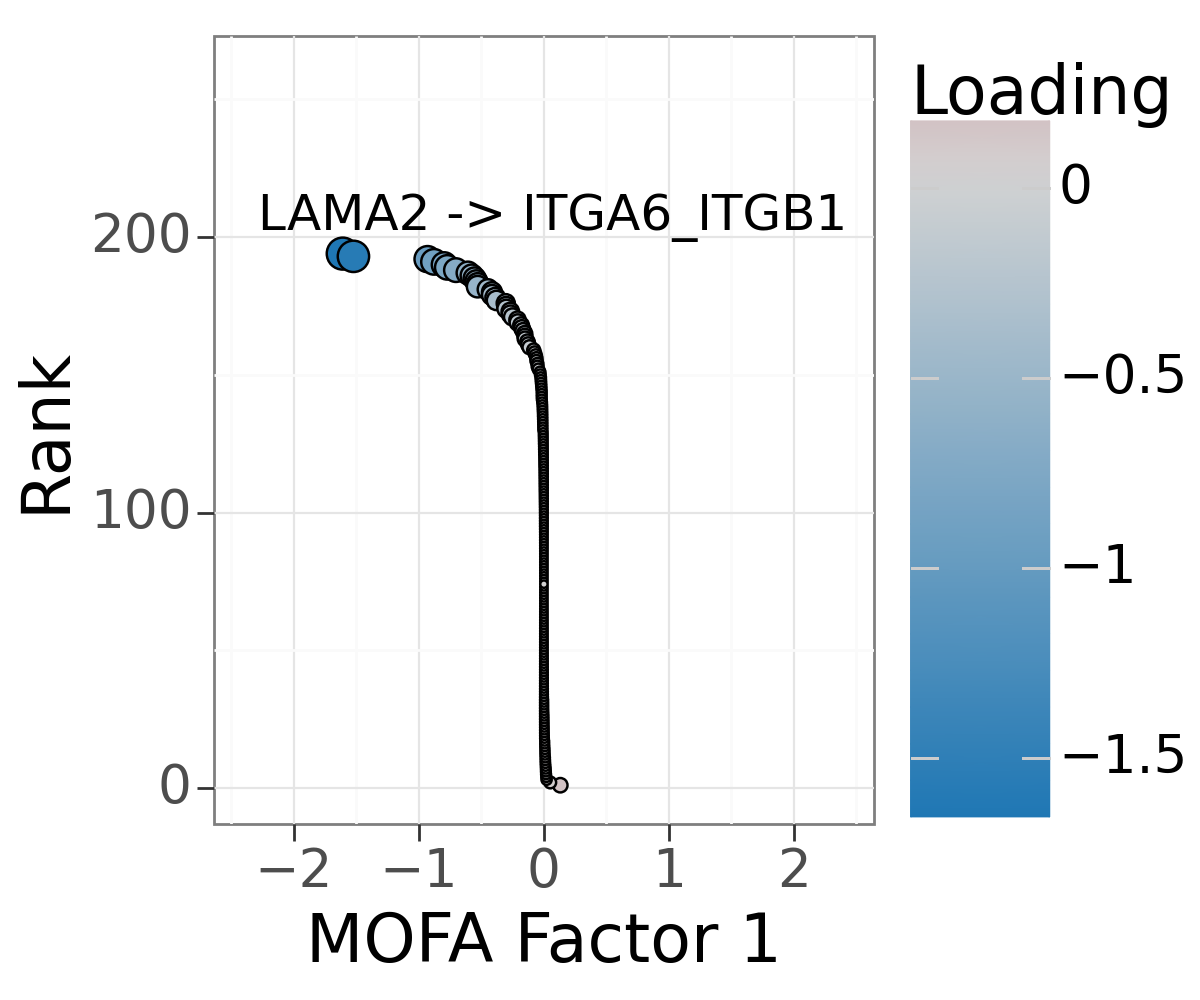

<Figure Size: (600 x 500)>

In [66]:
ct_int['size'] = ct_int['Factor1'].abs()
(
    p9.ggplot(ct_int) +
    p9.aes(x='Factor1', y='rank', fill='Factor1', size='size') +
    p9.geom_point() +
    p9.geom_text(p9.aes(label='name'), size=18, nudge_x=1, nudge_y=15) +
    p9.theme_bw(base_size=24) +
    p9.theme(figure_size=(6, 5)) +
    p9.scale_x_continuous(limits=(-2.4, 2.4)) +
    # scale rank to 0-200
    p9.scale_y_continuous(limits=(0, 260)) +
    p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) +
    p9.labs(x='MOFA Factor 1', y='Rank', fill='Loading') +
    # hide size
    p9.guides(size=False)
)

In [67]:
ct_int.sort_values("Factor1", key=abs, ascending=False)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
929,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.609031e+00,8.855203e-02,-2.848904e-02,-3.245843e-02,-1.711629e-02,-8.311809e-03,-8.161586e-03,1.026271e-02,1.818922e-02,2.147638e-03,1.609031e+00,194.0,
972,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.523540e+00,4.170503e-02,-2.580635e-03,1.575446e-02,-1.475022e-02,-1.452828e-02,-1.251072e-02,2.083366e-02,1.113622e-02,3.878267e-03,1.523540e+00,193.0,
930,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-9.306111e-01,-5.858301e-02,9.431674e-02,9.823108e-02,2.020069e-02,2.990360e-03,1.902639e-03,9.469684e-03,-4.785444e-03,1.627691e-03,9.306111e-01,192.0,LAMA2 -> ITGA6_ITGB1
853,CALM2,CACNA1C,Cardiomyocyte,Endothelial,-8.790719e-01,1.392351e-01,-2.773373e-02,-5.896601e-02,1.899566e-02,5.424591e-02,-1.174101e-03,1.503260e-02,3.124535e-02,-2.078612e-03,8.790719e-01,191.0,
931,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-7.977994e-01,3.009158e-02,6.510495e-02,3.880323e-02,6.695089e-02,2.031964e-03,1.744692e-02,5.831799e-03,-3.467447e-03,1.039855e-03,7.977994e-01,190.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,PSAP,SORT1,Cardiomyocyte,Endothelial,-2.733133e-08,2.715414e-08,2.417101e-01,1.865837e-07,9.979523e-08,7.160145e-08,4.362129e-09,-6.429297e-07,-7.938736e-08,4.186614e-08,2.733133e-08,75.0,
986,TGM2,ADGRG1,Cardiomyocyte,Endothelial,1.905261e-08,7.588218e-09,6.513417e-08,-4.858619e-07,2.210607e-01,4.192723e-08,9.440660e-09,-8.508678e-02,2.675740e-07,8.415371e-08,1.905261e-08,71.0,
865,CD99,PILRB,Cardiomyocyte,Endothelial,1.831974e-08,5.868670e-08,5.157742e-08,7.001706e-08,1.412173e-01,5.661564e-08,1.056659e-08,1.326223e-01,1.916575e-07,4.049937e-08,1.831974e-08,72.0,
874,COL1A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,1.547956e-08,-4.344372e-01,1.374738e+00,8.478033e-01,-2.093625e-05,-2.394787e-06,3.898600e-07,-1.697260e-01,6.249681e-06,7.050041e-06,1.547956e-08,73.0,


PyDESeq2

In [68]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
# import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

from matplotlib import pyplot as plt


AnnData

In [69]:
adata = sc.read_h5ad(os.path.join('kuppe_visium', 'kuppe_processed.h5ad'), backed='r')

Create Pseudobulk

In [70]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 273 × 26972
    obs: 'sample', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'
    layers: 'psbulk_props'

In [71]:
pdata.obs = pdata.obs[[sample_key, groupby, condition_key, "patient_region_id", "major_labl", "cell_type", "psbulk_n_cells", "psbulk_counts"]]

In [72]:
pdata.write_h5ad(os.path.join('kuppe_visium', 'kuppe_pseudobulk.h5ad'))

... storing 'sample' as categorical
... storing 'cell_type_original' as categorical
... storing 'patient_group' as categorical
... storing 'patient_region_id' as categorical
... storing 'major_labl' as categorical
... storing 'cell_type' as categorical


Normalize

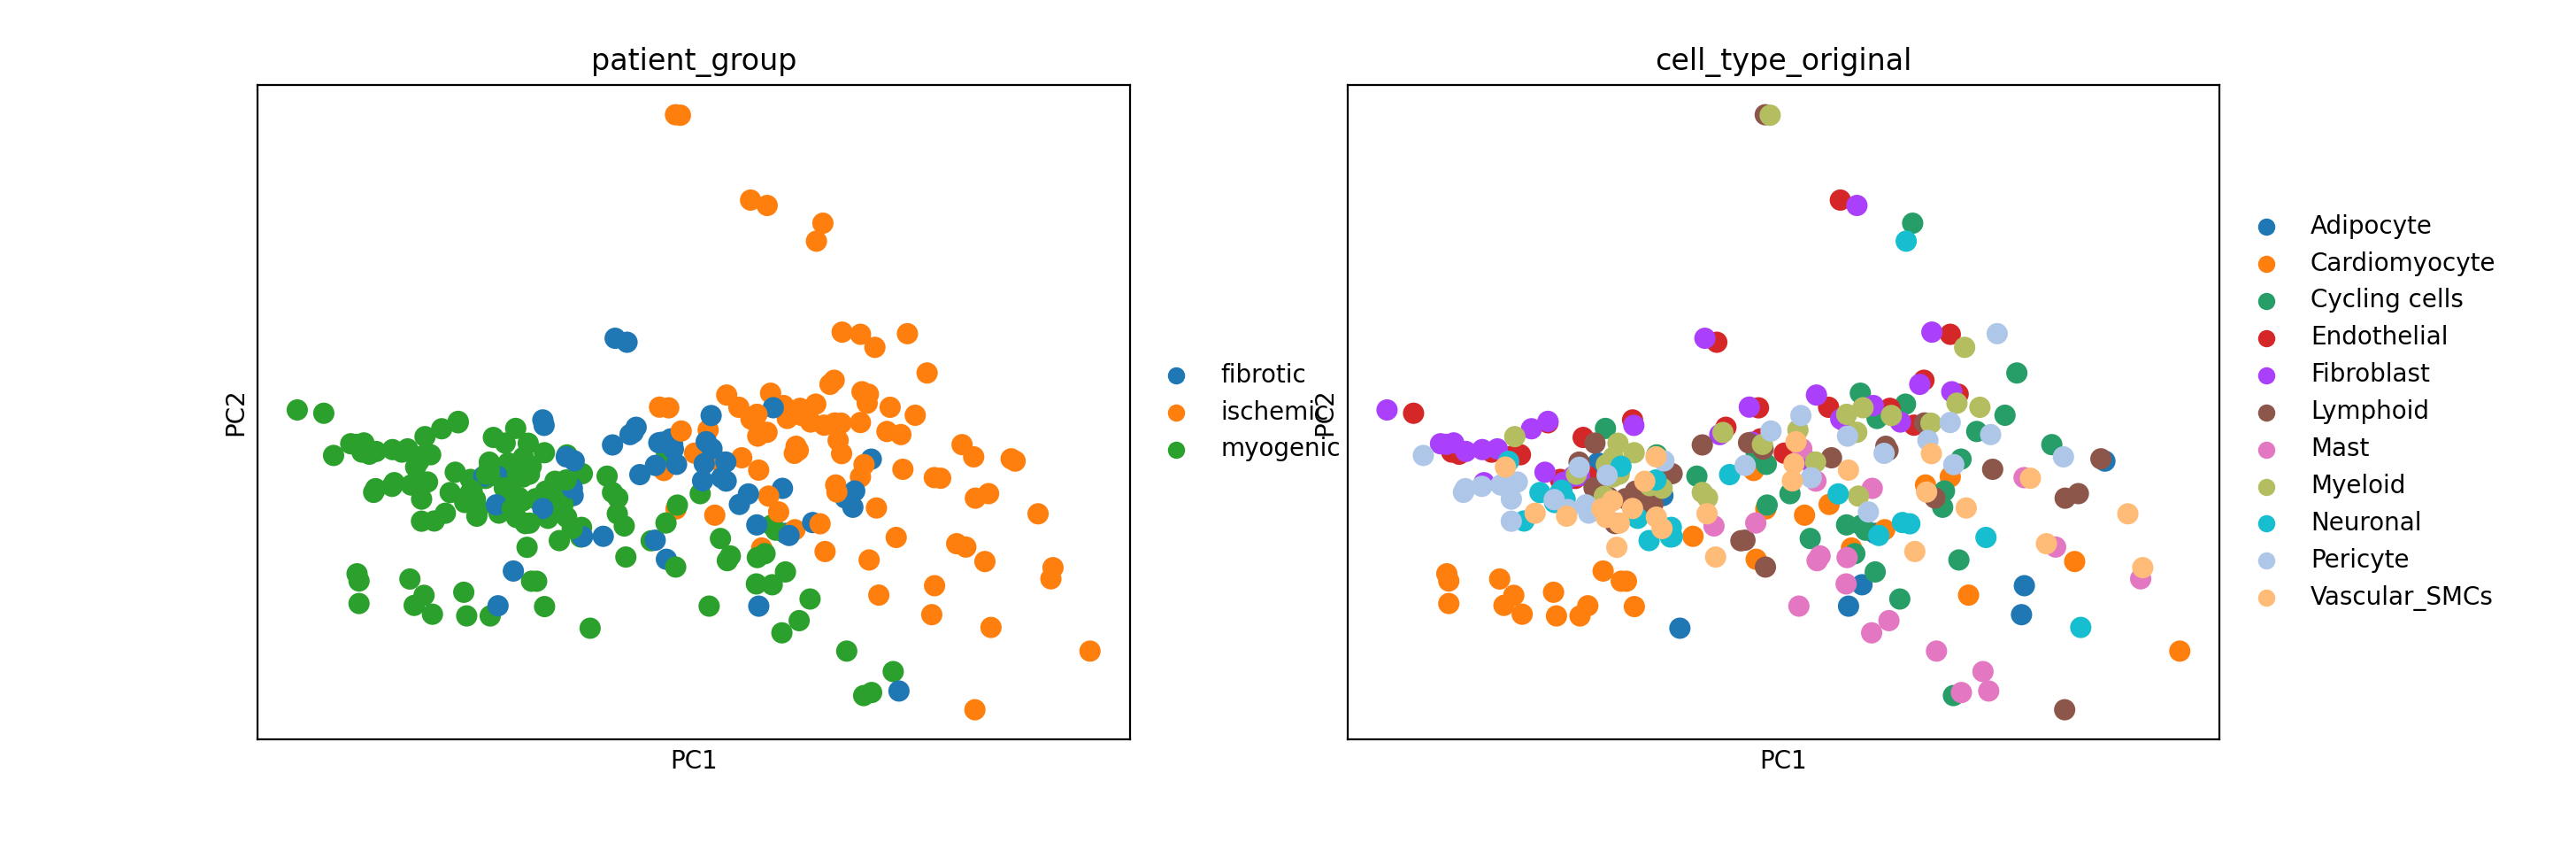

In [73]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

sc.pl.pca(pp_pdata, color=[condition_key, groupby], ncols=2, show=True, size=300)

In [74]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = [groupby, condition_key], #metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)



100%|██████████| 10/10 [00:00<00:00, 96.70it/s]


In [75]:
plt.figure(figsize=(7,10))
ax, legend_axes = dc.plot_associations(
    pp_pdata,
    uns_key='pca_anova',  # summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # which summary statistic to plot
    obs_annotation_cols = [groupby, condition_key], # which sample annotations to plot
)
plt.show()

ImportError: PyComplexHeatmap is not installed. Please install it using "pip install PyComplexHeatmap"

<Figure size 700x1000 with 0 Axes>

In [ ]:
# IZ vs Rest
pdata.obs['condition'] = 'Rest' # TODO: do on adata
pdata.obs.loc[pdata.obs[condition_key]=='ischemic', 'condition'] = 'IZ'

In [ ]:
condition_key = 'condition'
ref = "Rest"
cond = "IZ"

In [ ]:
min_count = 10
min_total_count = 20
large_n = 5
min_prop = 0.2

# plt with ax with same number as groups
fig, axes = plt.subplots(1, len(pdata.obs[groupby].unique()), figsize=(7*len(pdata.obs[groupby].unique()), 5))

for i, cell_group in enumerate(pdata.obs[groupby].unique()):
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n, min_prop=min_prop, ax =axes[i])

In [ ]:
%%capture
dea_results = {}


for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
        dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n)

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=min_count,
                              min_total_count=min_total_count,
                              large_n=large_n,
                              min_prop=min_prop
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'Rest'],
        refit_cooks=True,
        n_cpus=None,
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, cond, ref], n_cpus=8)
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff=f'{condition_key}_{cond}_vs_{ref}') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [ ]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby})
dea_df.set_index('feature_name', inplace=True)
dea_df.to_csv(os.path.join('kuppe_visium', 'kuppe_dea.csv'))

In [ ]:
dea_df.head()

Read DEA Results

In [ ]:
dea_df = pd.read_csv(os.path.join('kuppe_visium', 'kuppe_dea.csv'), index_col=0)

In [ ]:
# keep only iz
adata_s = adata[adata.obs['patient_group']=='ischemic', :] # change to condition key when in adata

In [ ]:
adata_s = adata_s.to_memory()

In [ ]:
adata_s.X = adata_s.layers['counts'].copy()


In [ ]:
adata_s.X.max()

In [ ]:
sc.pp.normalize_total(adata_s)
sc.pp.log1p(adata_s)
# NOTE: it's not already log-transformed (its something with the way it's saved)

In [ ]:
lr_res = li.multi.df_to_lr(adata_s,
                           dea_df=dea_df,
                           resource=resource,
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

TODO: Enable Filtering

In [ ]:
ints = pd.DataFrame(index=model.views)

In [ ]:
# split index by & into source and target
ints[['source', 'target']] = list(ints.index.str.split('&', 1, expand=True))

In [ ]:
ints

In [ ]:
# NOTE inner join with interactions
lr_res = lr_res.merge(ints, on=['source', 'target'], how='inner')

Pick interactions of interst based on R2

In [ ]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='interaction_expr',
                     inverse_size=False,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=25,
                     size_range=(0.1, 6)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, + limits for colour and mid point
    + p9.scale_color_cmap('RdBu_r', limits=(-5, 5), midpoint=0)
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(13, 7)) +
    p9.labs(color='Wald Statistic', size='Normalised Expression')
)

Save DE interactions -> go space

In [ ]:
lr_res.to_csv(os.path.join('kuppe_visium', 'kuppe_dea_interactions.csv'), index=False)

TFs

In [ ]:
net = dc.get_collectri(organism='human')

In [ ]:
from decoupler import p_adjust_fdr

In [ ]:
acts = {}

for cell_group in pdata.obs[groupby].unique():
    ct_df = dea_df[dea_df[groupby] == cell_group].copy()
    mat = ct_df[['stat']].T.rename(index={'stat': cell_group})
    
    # Infer pathway activities with ulm
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
    tf_acts = tf_acts.T.rename(columns={cell_group: 'activity'})
    tf_pvals = tf_pvals.T.rename(columns={cell_group: 'pvalue'})
    
    act = tf_acts.merge(tf_pvals, left_index=True, right_index=True)
    acts[cell_group] = act
    

In [ ]:
acts = pd.concat(acts)

In [ ]:
acts['fdr'] = p_adjust_fdr(acts['pvalue'])
acts = acts.reset_index(names=[groupby, 'tf'])

In [ ]:
acts.to_csv(os.path.join('kuppe_visium', 'kuppe_tf_activities.csv'), index=False)

In [ ]:
acts.sort_values("fdr").head()